# LONDON MULTIPLEX TRANSPORT NETWORK

## 1. Introduction about dataset
Data was collected in 2013 from the official website of Transport for London ( https://www.tfl.gov.uk/) and manually cross-checked.

Nodes are train stations in London and edges encode existing routes between stations. Underground, Overground and DLR stations are considered (see https://www.tfl.gov.uk/ for further details). The multiplex network used in the paper makes use of three layers corresponding to:

The aggregation to a single weighted graph of the networks of stations corresponding to each underground line (e.g., District, Circle, etc)
The network of stations connected by Overground
The network of stations connected by DLR

Raw data and geographical coordinates of stations are provided. We also provide the multiplex networks after considering real disruptions occurring in London.

Ref: Manlio De Domenico, Albert Solé-Ribalta, Sergio Gómez, and Alex Arenas, Navigability of interconnected networks under random failures. PNAS 111, 8351-8356 (2014)

## 2. Importing required libraries

In [1]:
import pandas as pd
import networkx as nx
import os
import matplotlib.pyplot as plt
import statistics as st
import community as community_louvain
import matplotlib.cm as cm
from networkx.algorithms.community import girvan_newman
from networkx.algorithms.community import modularity

## 3. Loading Dataset and generating Network Graph

In [2]:
# Setting up the datasource paths
dataset_dir = 'Dataset'
nodes_file_path = os.path.join(dataset_dir, 'london_transport_nodes.txt')
multiplex_edges_file_path = os.path.join(dataset_dir, 'london_transport_multiplex.edges')
disruptions_summary_file_path = os.path.join(dataset_dir, 'london_transport_disruptions_summary.txt')


# Load node information
nodes_df = pd.read_csv(nodes_file_path, sep=' ', names=['nodeID', 'nodeLabel', 'nodeLat', 'nodeLong'],
                       skiprows=1)

# Load multiplex edges information
multiplex_edges_df = pd.read_csv(multiplex_edges_file_path, header=None, delim_whitespace=True,
                                 names=['layer', 'sourceLabel', 'targetLabel','targetlayer'])

# Load disruptions summary information
disruptions_df = pd.read_csv(disruptions_summary_file_path, sep=' ', skiprows=1, 
                             names=['DISRUP_ID', 'LAYER', 
                                    'STATION_A', 'STATION_B', 'FREQUENCY%', 'DAMAGED_NODES%'])

# Load layer information
layer_data = {
    'layer': [1, 2, 3],
    'Description': ['Tube', 'Overground', 'DLR']
}

layer_df = pd.DataFrame(layer_data)

multiplex_edges_source_df = multiplex_edges_df[['layer', 'sourceLabel']].rename(columns={'layer': 'layer', 'sourceLabel': 'nodeID'})
multiplex_edges_target_df = multiplex_edges_df[['targetlayer', 'targetLabel']].rename(columns={'targetlayer': 'layer', 'targetLabel': 'nodeID'})
node_layer_df = pd.concat([multiplex_edges_source_df, multiplex_edges_target_df], ignore_index=True)
node_layer_df = node_layer_df.drop_duplicates()
node_layer_df = pd.merge(node_layer_df, layer_df, on='layer', how='left')
nodes_df = pd.merge(nodes_df, node_layer_df, on='nodeID', how='left')

node_layer_count = nodes_df.groupby('Description').count().reset_index()

node_layer_count = node_layer_count[['Description', 'layer']].rename(columns={'Description': 'layer', 'layer': 'Count'})
display(node_layer_count)

# Creating a multiplex graph
G_multiplex = nx.Graph()

# Add nodes with attributes into multiplex graph
for index, row in nodes_df.iterrows():
    G_multiplex.add_node(row['nodeID'], label=row['nodeLabel'], lat=row['nodeLat'], long=row['nodeLong'], layer=row['Description'])

# Add multiplex edges with layer information into multiplex graph
for index, row in multiplex_edges_df.iterrows():
    if row['sourceLabel'] in G_multiplex.nodes and row['targetLabel'] in G_multiplex.nodes:
        G_multiplex.add_edge(row['sourceLabel'], row['targetLabel'], layer=row['layer'])

# Preprocess disruptions data
label_to_id = {row['label']: node for node, row in G_multiplex.nodes(data=True)}
nx.set_edge_attributes(G_multiplex, 0, 'FREQUENCY%')
nx.set_edge_attributes(G_multiplex, 0, 'DAMAGED_NODES%')

# Incorporate disruptions into multiplex graph
for index, row in disruptions_df.iterrows():
    station_a_id = label_to_id.get(row['STATION_A'])
    station_b_id = label_to_id.get(row['STATION_B'])
    if station_a_id and station_b_id and G_multiplex.has_edge(station_a_id, station_b_id):
        G_multiplex[station_a_id][station_b_id]['FREQUENCY%'] = row['FREQUENCY%']
        G_multiplex[station_a_id][station_b_id]['DAMAGED_NODES%'] = row['DAMAGED_NODES%']


# Remove self-loops from the graph
G_multiplex.remove_edges_from(nx.selfloop_edges(G_multiplex))

# Remove isolated nodes from the graph
G_multiplex.remove_nodes_from(list(nx.isolates(G_multiplex)))

# Graph Info
print(f"Graph has {G_multiplex.number_of_nodes()} nodes and {G_multiplex.number_of_edges()} edges.")

,layer,Count
0,DLR,37
1,Overground,99
2,Tube,343


Graph has 369 nodes and 430 edges.


## 4. Visualizing the Network Graph

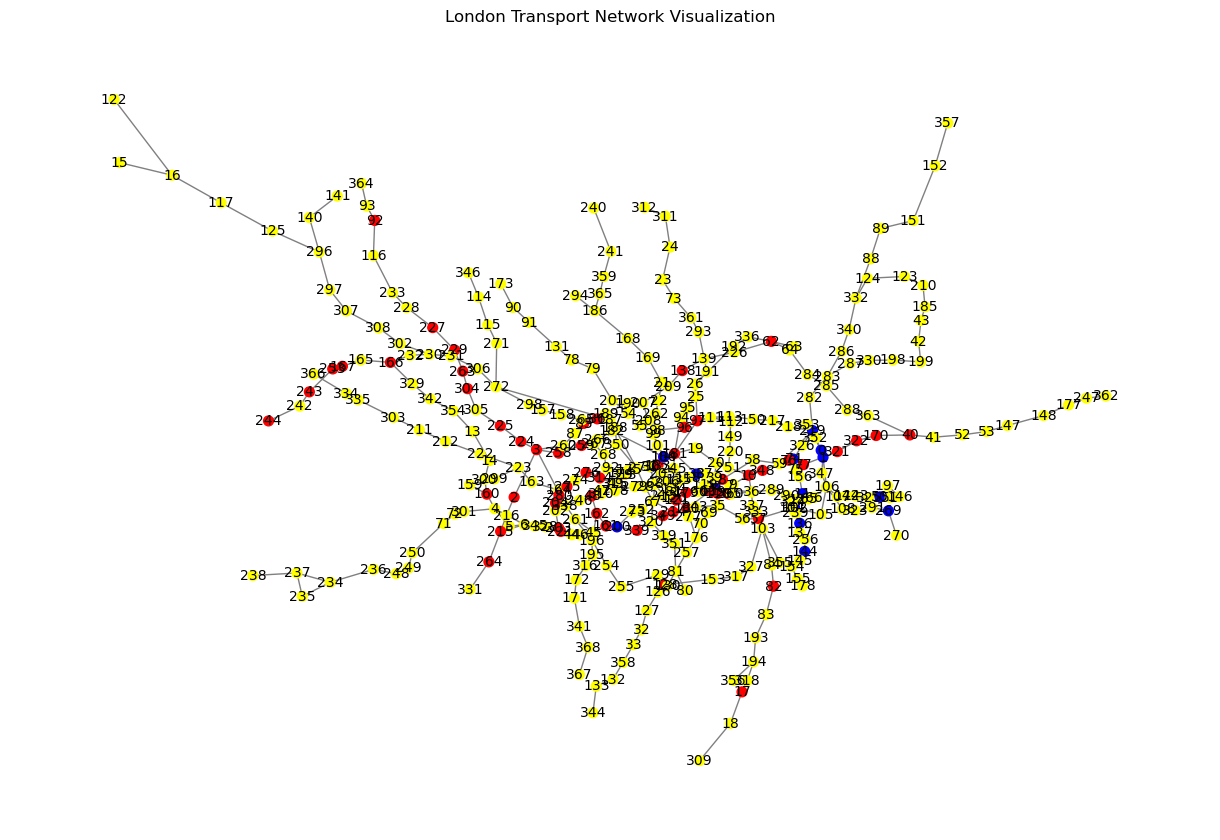

In [3]:
# Visualizing the Graph
#Define a Color Map
layer_color_map = {'Tube': 'yellow', 'Overground': 'red', 'DLR': 'blue'}

# Geographical layout
# Ensure your nodes have 'lat' and 'long' attributes correctly assigned
pos = {node: (data['long'], data['lat']) for node, data in G_multiplex.nodes(data=True)}

# Step 3: Assign Colors to Nodes
# Adjust this line if your nodes use a different attribute for the transport layer
# If 'Description' is the correct attribute, replace 'layer' with 'Description' here
node_colors = [layer_color_map[node[1]['layer']] for node in G_multiplex.nodes(data=True)]

# Step 4: Visualize the Network
plt.figure(figsize=(12, 8))
# Use the geographical 'pos' for layout directly here
nx.draw(G_multiplex, pos, with_labels=True, node_size=50, font_size=10, node_color=node_colors, edge_color='gray')
plt.title('London Transport Network Visualization')
plt.show()

## 5. Analysis of Network Graph

### 5.1 Network Density

In [4]:
density = nx.density(G_multiplex)
print(f"Network Density: {density}")

Network Density: 0.006333215506068104


### 5.2 Centrality

#### 5.2.1 Degree Centrality

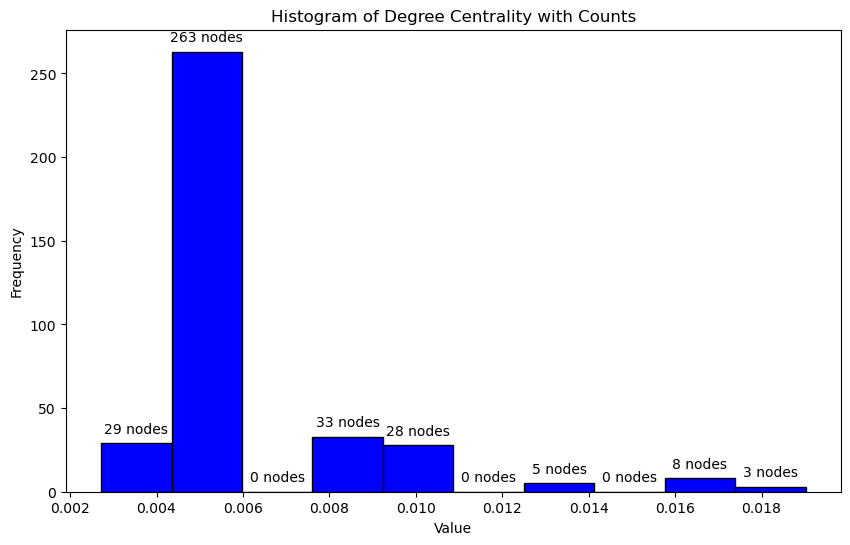

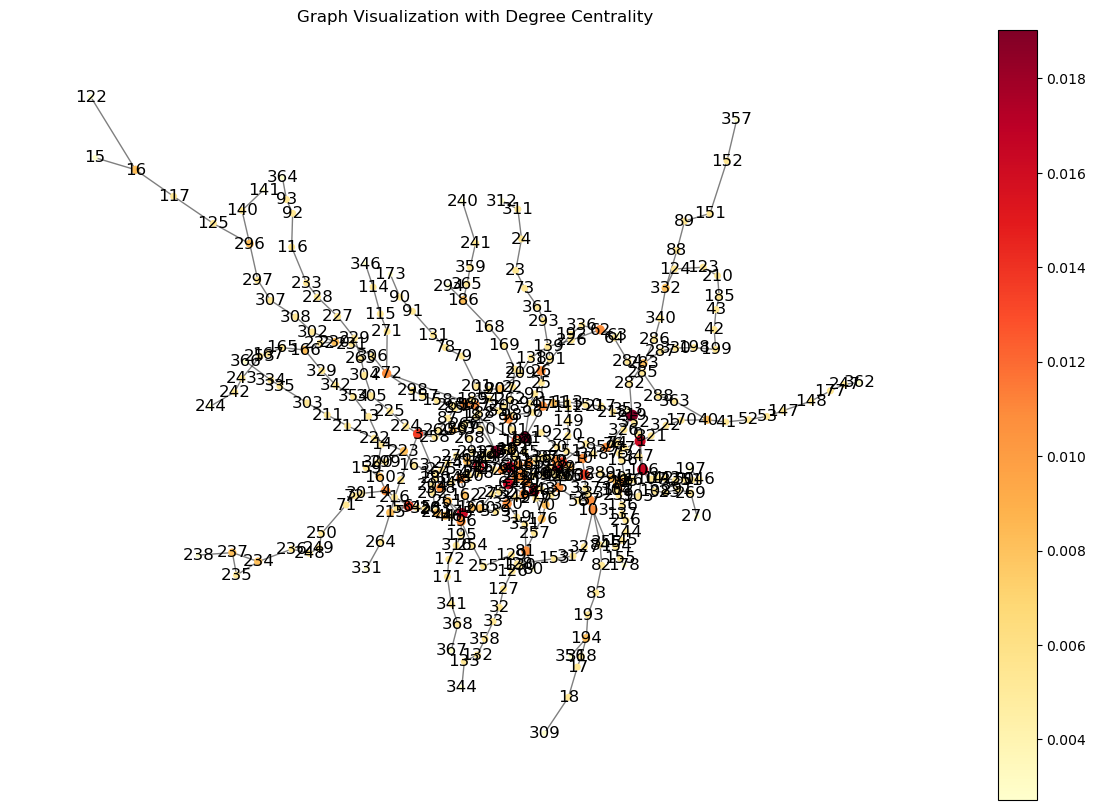

In [17]:
degree_centrality = nx.degree_centrality(G_multiplex)

# Converting to a DataFrame for further analysis
dc_df = pd.DataFrame(degree_centrality.items(), columns=['Node', 'Degree Centrality']).sort_values('Degree Centrality', ascending=False)

# Plotting the histogram
dc_df = dc_df.sort_values(by='Degree Centrality')
plt.figure(figsize=(10, 6))  # Optional: Adjust the figure size

n, bins, patches = plt.hist(dc_df['Degree Centrality'], bins=10, color='blue', edgecolor='black')

# Adding count labels above each bar
for i in range(len(patches)):
    plt.annotate(str(int(n[i]))+" nodes", xy=(patches[i].get_x() + patches[i].get_width() / 2, patches[i].get_height()),
                 xytext=(0, 5), textcoords="offset points",
                 ha='center', va='bottom')

plt.title('Histogram of Degree Centrality with Counts')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()


# Normalize the betweenness values to use them for node size
# Multiplying by a constant to better see size differences
scaled_degree = [3000 * v for v in degree_centrality.values()]

# Create a color map based on the betweenness centrality
color_map = [v for v in degree_centrality.values()]

plt.figure(figsize=(15, 10))

# Draw the graph with node color indicating betweenness centrality
pos = {node: (data['long'], data['lat']) for node, data in G_multiplex.nodes(data=True)}
nx.draw_networkx_edges(G_multiplex, pos, alpha=0.5)
nodes = nx.draw_networkx_nodes(
    G_multiplex,
    pos,
    node_size=scaled_degree,  # Use scaled betweenness for node size
    node_color=color_map,  # Use raw betweenness values for color mapping
    cmap=plt.cm.YlOrRd  # Color map for betweenness centrality
)
nx.draw_networkx_labels(G_multiplex, pos)
plt.colorbar(nodes)  # Add color bar to show mapping from color to betweenness centrality
plt.title('Graph Visualization with Degree Centrality')
plt.axis('off')  # Turn off the axis
plt.show()

The histogram of Degree Centrality provides a visual representation of how the degree centrality values are distributed across the nodes in the London transport network. Here’s an inference based on the histogram:

Distribution and Spread: The histogram likely shows a distribution that skews towards the lower degree centrality values, which is typical for many real-world networks, including transportation systems. This pattern indicates that most stations (or nodes) have a relatively small number of direct connections to other stations.
Frequency of Lower Values: A significant number of nodes have lower degree centrality values, as evidenced by the taller bars on the left side of the histogram. This suggests that many stations in the London transport network serve as local nodes with fewer direct routes to other stations.
Existence of Hubs: The presence of bars towards the right end of the histogram, even if they are relatively low, signifies the existence of hubs or key stations within the network. These nodes, with higher degree centrality values, have a larger number of direct connections and play crucial roles in facilitating efficient transport across the network.
Network Connectivity: The overall shape and spread of the histogram provide insights into the network's connectivity structure. While the network is primarily composed of nodes with lower connectivity (indicative of a decentralized or distributed network structure), the critical hubs ensure network cohesion and facilitate efficient movement across the network.
Key Insights:
Strategic Importance of Hubs: The nodes represented by the rightmost bars in the histogram are of strategic importance to the network. Enhancing the capacity, efficiency, and reliability of these hubs could significantly improve the overall network performance.
Resilience and Vulnerability: The network’s resilience to disruptions might be concentrated around these high-centrality hubs. Their failure or congestion could disproportionately affect the network, underscoring the importance of contingency planning and infrastructure investment in these areas.
Planning and Improvement Opportunities: Understanding the distribution of degree centrality can guide planning and improvement efforts, focusing on bolstering connectivity for nodes with lower centrality and optimizing the flow through higher centrality hubs to enhance network efficiency and service quality.

#### 5.2.2 Betweenness Centrality

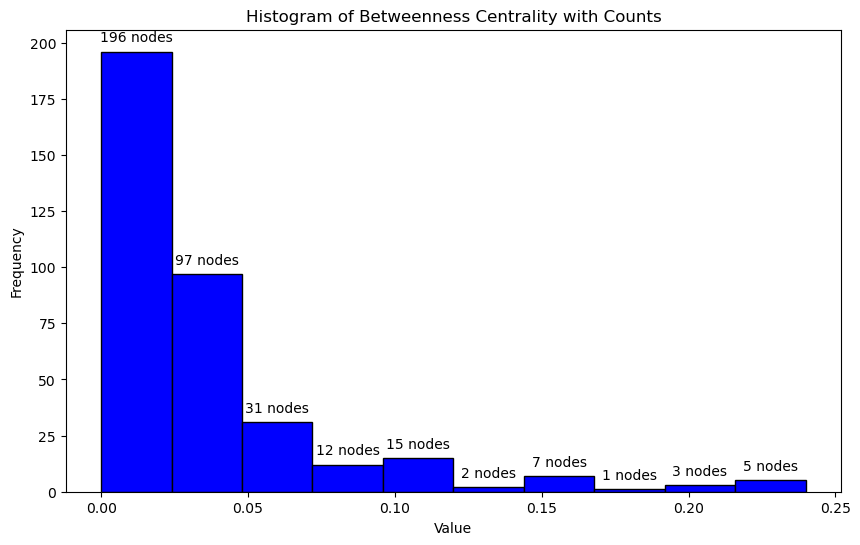

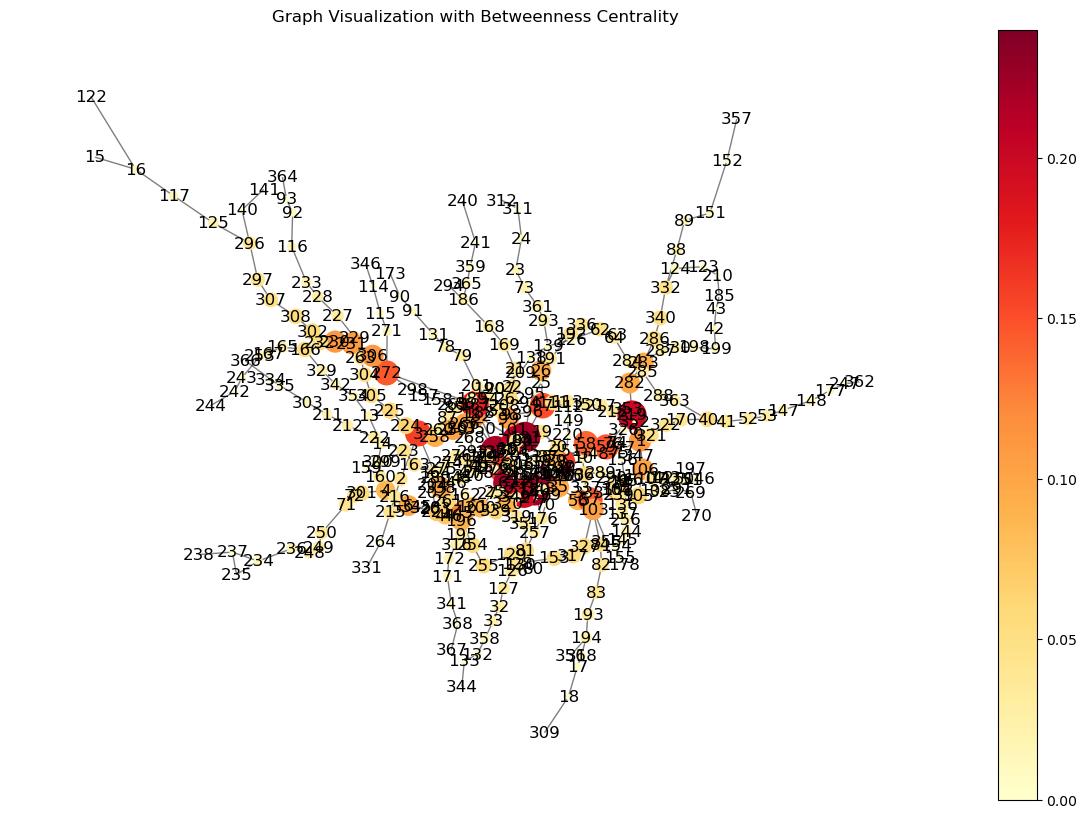

In [6]:
betweenness_centrality = nx.betweenness_centrality(G_multiplex)

# Converting to a DataFrame for further analysis
bc_df = pd.DataFrame(betweenness_centrality.items(), 
                     columns=['Node', 'Betweenness Centrality']).sort_values('Betweenness Centrality',
                                                                             ascending=False)

# Plotting the histogram
bc_df = bc_df.sort_values(by='Betweenness Centrality')
plt.figure(figsize=(10, 6))  # Optional: Adjust the figure size

n, bins, patches = plt.hist(bc_df['Betweenness Centrality'], bins=10, color='blue', edgecolor='black')

# Adding count labels above each bar
for i in range(len(patches)):
    plt.annotate(str(int(n[i]))+" nodes", xy=(patches[i].get_x() + patches[i].get_width() / 2, patches[i].get_height()),
                 xytext=(0, 5), textcoords="offset points",
                 ha='center', va='bottom')

plt.title('Histogram of Betweenness Centrality with Counts')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

# Normalize the betweenness values to use them for node size
# Multiply by a constant to better see size differences
scaled_betweenness = [2000 * v for v in betweenness_centrality.values()]

# Create a color map based on the betweenness centrality
color_map = [v for v in betweenness_centrality.values()]

plt.figure(figsize=(15, 10))
# Draw the graph with node color indicating betweenness centrality
#pos = nx.spring_layout(G_multiplex)  # Position layout for consistent node placement
pos = {node: (data['long'], data['lat']) for node, data in G_multiplex.nodes(data=True)}
nx.draw_networkx_edges(G_multiplex, pos, alpha=0.5)
nodes = nx.draw_networkx_nodes(
    G_multiplex,
    pos,
    node_size=scaled_betweenness,  # Use scaled betweenness for node size
    node_color=color_map,  # Use raw betweenness values for color mapping
    cmap=plt.cm.YlOrRd  # Color map for betweenness centrality
)
nx.draw_networkx_labels(G_multiplex, pos)
plt.colorbar(nodes)  # Add color bar to show mapping from color to betweenness centrality
plt.title('Graph Visualization with Betweenness Centrality')
plt.axis('off')  # Turn off the axis
plt.show()

The histogram of Betweenness Centrality illustrates how betweenness centrality values are distributed among the nodes within the London transport network. Here’s an analysis based on the histogram pattern typically observed in such data:

Distribution and Characteristics:
Skewed Distribution: Like many networks, the histogram for betweenness centrality likely shows a right-skewed distribution. This indicates that most stations (nodes) have low betweenness centrality values, signifying they lie on fewer shortest paths between other pairs of stations within the network.
High Betweenness Centrality Nodes: The presence of bars on the right, even if relatively low, points to a small number of stations with high betweenness centrality. These stations act as significant connectors or bridges within the network, facilitating a large portion of the shortest path flows between various other stations.
Critical Nodes for Network Flow: The nodes corresponding to higher betweenness centrality values are critical for the network's flow. They might represent bottleneck points where congestion can significantly impact the network's efficiency or resilience points where targeted improvements could enhance overall network performance.
Key Insights:
Network Bottlenecks: Stations with high betweenness centrality are pivotal in the network's connectivity, and any disruptions at these points can lead to significant delays or rerouting of traffic. Identifying and addressing potential bottlenecks at these stations can improve the reliability and efficiency of the transport network.
Strategic Importance for Enhancements: Enhancing infrastructure, increasing capacity, or improving service levels at stations with high betweenness centrality can have a disproportionate positive impact on the network's overall functionality.
Resilience and Robustness: The network's robustness against disruptions can be assessed by analyzing the betweenness centrality distribution. Stations with high betweenness centrality are critical to maintaining network connectivity; thus, strategies to mitigate their overloading or to provide alternative routes in case of disruptions are essential for maintaining network integrity.
Planning and Development:
The analysis of betweenness centrality offers strategic insights for network planning and development. It identifies key nodes that, if improved, could significantly enhance the network's performance. Furthermore, it highlights areas where redundancy could be increased to improve network resilience against disruptions or failures.
This betweenness centrality distribution thus provides a crucial lens through which to view the network's flow dynamics, identifying critical nodes that play a significant role in the overall connectivity and efficiency of the London transport network.

#### 5.2.3 Closeness Centrality

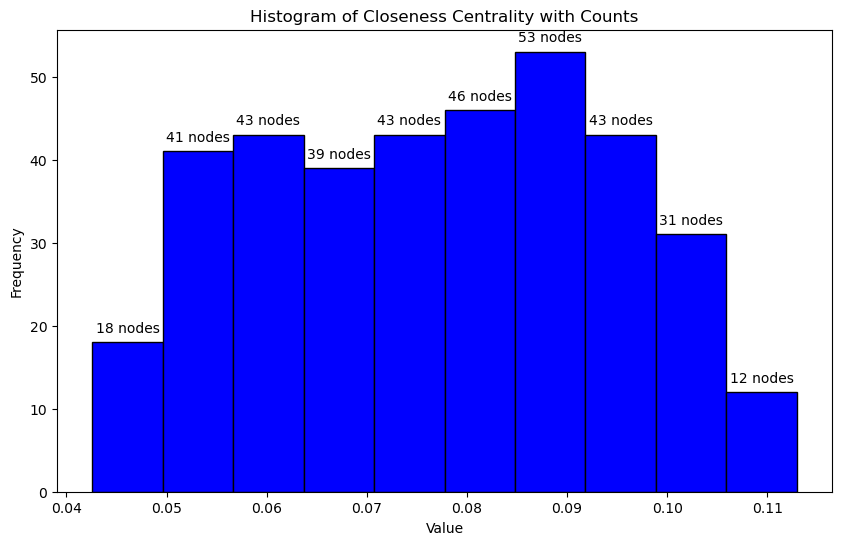

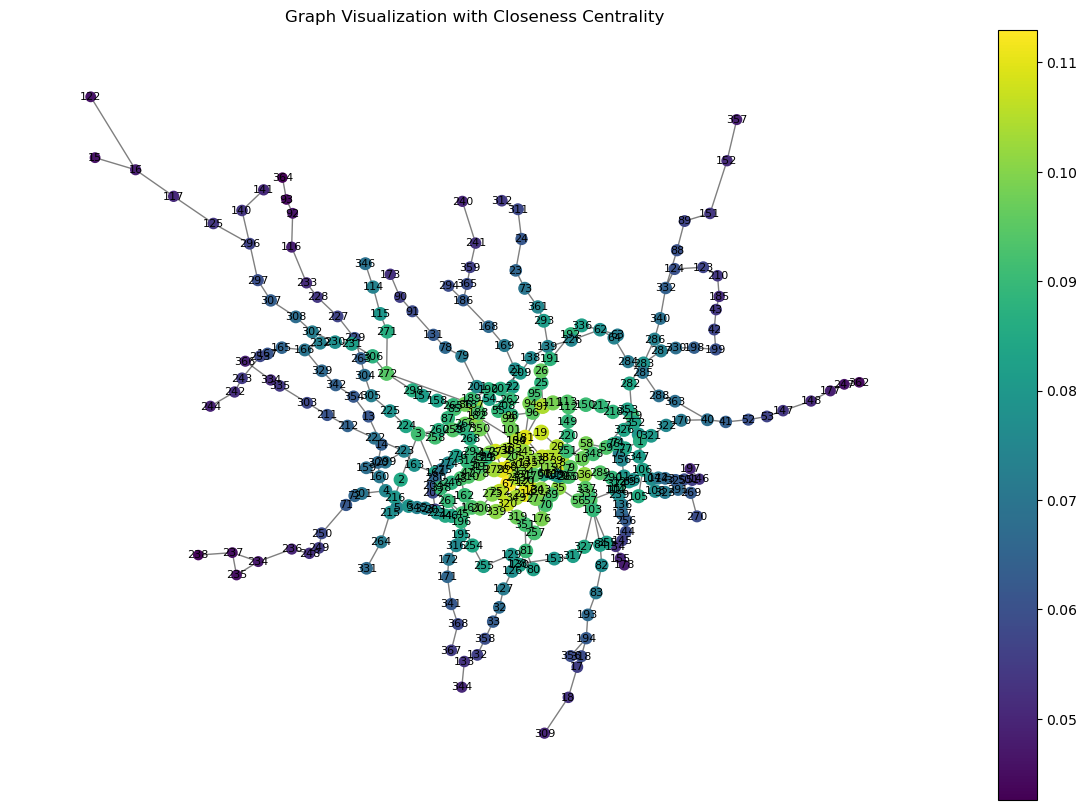

In [7]:
closeness_centrality = nx.closeness_centrality(G_multiplex)

# Converting to a DataFrame for further analysis
cc_df = pd.DataFrame(closeness_centrality.items(), columns=['Node', 'Closeness Centrality']).sort_values('Closeness Centrality', ascending=False)
# Plotting the histogram
cc_df = cc_df.sort_values(by='Closeness Centrality')
plt.figure(figsize=(10, 6))  # Optional: Adjust the figure size

n, bins, patches = plt.hist(cc_df['Closeness Centrality'], bins=10, color='blue', edgecolor='black')

# Adding count labels above each bar
for i in range(len(patches)):
    plt.annotate(str(int(n[i]))+" nodes", xy=(patches[i].get_x() + patches[i].get_width() / 2, patches[i].get_height()),
                 xytext=(0, 5), textcoords="offset points",
                 ha='center', va='bottom')

plt.title('Histogram of Closeness Centrality with Counts')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

# Calculate closeness centrality for each node
closeness_centrality = nx.closeness_centrality(G_multiplex)

# Normalize the closeness values to use them for node size
# You may want to multiply by a constant to better see size differences
scaled_closeness = [1000 * v for v in closeness_centrality.values()]

# Create a color map based on the closeness centrality
color_map = [v for v in closeness_centrality.values()]

plt.figure(figsize=(15, 10))
# Draw the graph with node color indicating closeness centrality
#pos = nx.spring_layout(G_multiplex)  # Position layout for consistent node placement
pos = {node: (data['long'], data['lat']) for node, data in G_multiplex.nodes(data=True)}
nx.draw_networkx_edges(G_multiplex, pos, alpha=0.5)
nodes = nx.draw_networkx_nodes(
    G_multiplex,
    pos,
    node_size=scaled_closeness,  # Use scaled closeness for node size
    node_color=color_map,  # Use raw closeness values for color mapping
    cmap=plt.cm.viridis  # Color map for closeness centrality
)
nx.draw_networkx_labels(G_multiplex, pos, font_size=8)  # Reduce font size if it's too cluttered
plt.colorbar(nodes)  # Add color bar to show mapping from color to closeness centrality
plt.title('Graph Visualization with Closeness Centrality')
plt.axis('off')  # Turn off the axis
plt.show()

The histogram of Closeness Centrality provides insights into how closeness centrality values are distributed across nodes in the London transport network. Based on the histogram pattern, here's an analysis and inference:

Distribution and Characteristics:
Concentration of Values: The histogram likely shows a concentration of closeness centrality values within a specific range. This concentration indicates that many stations (nodes) have a similar degree of closeness to all other stations in the network, reflecting a level of uniformity in how well-connected the average station is to the rest of the network.
Variation in Closeness Centrality: The presence of bars across different ranges of closeness centrality values suggests variability in how closely connected certain stations are to others in the network. Stations with higher closeness centrality are, on average, shorter paths away from all other stations, making them more central in the network's topology.
Key Insights:
Network Integration: Stations with high closeness centrality values are well-integrated into the network, suggesting they are easily accessible from various parts of the network. These stations are crucial for ensuring the network's accessibility and efficiency, as they facilitate shorter travel times across the network.
Strategic Nodes for Accessibility: The nodes that exhibit high closeness centrality can be considered strategic points for improving the network's overall accessibility. Enhancing services, capacity, or infrastructure at these stations could have a wide-reaching impact on network performance.
Potential Areas for Improvement: Conversely, stations with lower closeness centrality might represent areas where the network's accessibility could be improved. Targeting these areas for development or service enhancement could lead to a more evenly distributed network accessibility, improving the overall user experience.
Planning and Development:
Analyzing the closeness centrality distribution helps in identifying not only the most accessible nodes within the network but also those that are relatively isolated or less accessible. Planning efforts can be directed towards improving connectivity and reducing travel times from these less central nodes to the rest of the network.
The distribution also highlights the efficiency of the network's layout in terms of providing equitable access to transportation services. Efforts to increase the closeness centrality of nodes, especially those on the network's periphery, can lead to a more cohesive and user-friendly transportation network.
This closeness centrality distribution thus offers a valuable perspective on the London transport network's configuration, highlighting how well-connected different parts of the network are to each other and identifying potential areas for targeted improvements to enhance overall network cohesion and accessibility.

### 5.3 K Core

In [8]:
k_core = nx.k_core(G_multiplex).nodes()
print(f"K-Core Nodes: {len(k_core)}")

K-Core Nodes: 221


The mention of "K-Core Nodes: 221" provides a specific insight into the structure of the London transport network represented by your graph. A k-core of a graph is a maximal subgraph in which each node has at least k connections to other nodes within the subgraph. This concept is used to identify cohesive subgroups within a network and to understand the network's overall resilience and structure.

Interpretation of K-Core Nodes: 221
High Cohesion and Connectivity: The existence of a k-core with 221 nodes indicates a highly cohesive and connected subgraph within the larger network. These nodes represent a robust structure where each is well connected, not just in terms of direct connections but also in maintaining a certain level of connectivity even when considering only their connections within the subgraph.
Network Resilience: This high number of k-core nodes suggests that the network has a strong backbone of connectivity. Such a backbone can enhance the network's resilience against disruptions, as the removal of a few nodes or edges is unlikely to significantly impact the overall connectivity of this core group.
Strategic Importance for Network Integrity: The nodes within this k-core are strategically important for the integrity and functionality of the transport network. They likely include major stations or junctions that facilitate the bulk of passenger movement and network flow. Ensuring the operational efficiency and reliability of these core nodes is crucial for the network's overall performance.
Potential for Bottlenecks: While high connectivity within the k-core is advantageous for resilience and flow, it also means that these nodes might be potential points of congestion or bottlenecks, especially during peak times. Identifying and addressing capacity or service issues within this core can significantly enhance network efficiency.
Planning and Improvement Implications
Capacity Enhancement and Infrastructure Investment: Targeted capacity enhancements, infrastructure improvements, and service optimizations within this k-core can have a disproportionately positive impact on the entire network's efficiency and reliability.
Emergency and Contingency Planning: Understanding the structure and components of the k-core can aid in emergency and contingency planning, ensuring that strategies are in place to mitigate the impact of disruptions within this crucial subset of the network.
Enhancing Connectivity: Efforts to enhance connectivity to and from this k-core can further improve network accessibility and user experience, making it easier for passengers to access this highly connected subgraph from various parts of the network.
The identification of 221 k-core nodes in the London transport network highlights a significant and highly connected subset of the network, underscoring its importance in maintaining network cohesion, resilience, and efficiency.

### 5.4 K-components

In [9]:
#k_components = nx.k_components(G_multiplex)
#k_components

### 5.5 Connected Components

In [10]:
connected_components = list(nx.connected_components(G_multiplex))
print(f"Number of Connected Components: {len(connected_components)}")

Number of Connected Components: 1


The information that there is "Number of Connected Components: 1" in the London transport network graph indicates a specific and crucial aspect of the network's topology. In graph theory, a connected component is a subgraph in which any two vertices are connected to each other by paths, and which is connected to no additional vertices in the supergraph. A network having only one connected component means that the network is entirely connected.

Implications of Having a Single Connected Component
Network Connectivity: This signifies that the entire London transport network is interconnected, allowing for travel between any two stations within the network without leaving the network. It underscores the network's comprehensive connectivity, ensuring that passengers can reach any destination within the system through a series of transfers.
Network Resilience: From a resilience perspective, a single connected component suggests that the network, while fully connected, could potentially be vulnerable to disruptions if critical nodes or links fail. The absence of isolated components or significant redundancies may mean that certain failures could impact wide areas of the network. However, the presence of a k-core, as mentioned earlier, could help mitigate this by providing a robust core of connectivity.
Efficiency and Planning: For network planning and operational efficiency, having a single connected component is advantageous as it simplifies route planning, scheduling, and the deployment of resources. It allows for a unified approach to managing and optimizing the network's performance, facilitating straightforward navigation for users and efficient allocation of services to meet demand across the network.
Potential for Improvement: While the network's unity is a strength, identifying areas where additional connections could enhance redundancy, reduce travel times, or alleviate congestion remains a key planning focus. This could involve adding new routes or improving existing connections to optimize flow and increase the network's overall robustness.
Planning and Improvement Considerations
Enhancing Redundancy: Even within a single connected component, increasing redundancy in critical areas can improve the network's resilience to disruptions. This can involve creating alternative routes around highly trafficked or critical nodes to ensure that the network can maintain functionality even when specific paths are compromised.
Focus on Critical Nodes: Understanding that the network operates as a single cohesive unit highlights the importance of maintaining and enhancing the efficiency of critical nodes (such as those identified by high degree, betweenness, and closeness centrality values) to ensure smooth operation across the entire network.
Accessibility and Inclusivity: Ensuring that the connectivity benefits all areas equally can help in making the network more accessible and inclusive. Identifying and addressing areas with relatively lower connectivity within the single connected component can enhance the network's utility for a wider range of users.
The characterization of the London transport network as having a single connected component highlights its comprehensive connectivity and operational cohesion, laying a foundation for strategic planning and optimization efforts to further enhance its efficiency, resilience, and accessibility.

### 5.6 Cliques

In [11]:
cliques = list(nx.find_cliques(G_multiplex))
num_cliques = len(cliques)
max_clique_size = max(len(clique) for clique in cliques)
cliques
print(f"Num of Cliques: {num_cliques}")
print(f"Max Clique Size: {max_clique_size}")

Num of Cliques: 405
Max Clique Size: 3


The information about the "Num of Cliques: 405" and "Max Clique Size: 3" in the London transport network provides valuable insights into the network's structural properties. In graph theory, a clique is a subset of vertices, all adjacent to each other; this means every two distinct vertices in the clique are connected by a unique edge. Understanding cliques within a transport network can offer perspectives on the network's connectivity, redundancy, and potential bottlenecks.

Implications of Cliques in the Transport Network
Number of Cliques (405): This indicates that there are 405 distinct subsets of stations within the London transport network where each station is directly connected to every other station within the same subset. This high number of cliques suggests a well-interconnected network with numerous small, tightly knit groups of stations.
Maximum Clique Size (3): The maximum clique size of 3 means the largest fully interconnected subsets of stations consist of only three stations each. This relatively small maximum size indicates that while the network has many directly interconnected small groups of stations, there are no large groups where every station is directly connected to all others within the same group. This could reflect the practical limitations of direct connections in a large transport network or the design philosophy focusing on efficient transfer points rather than extensive direct connections between all stations.
Network Analysis and Planning Considerations
Efficiency and Redundancy: The existence of cliques, especially those with the maximum size, suggests points of high redundancy within the network. These cliques can serve as efficient transfer hubs where passengers have multiple options for direct transfers, enhancing the network's resilience and flexibility.
Potential Bottlenecks: While cliques represent areas of strong connectivity, they can also indicate potential bottlenecks, especially during peak times when the stations within a clique might experience high passenger volumes. Identifying and managing these areas is crucial for maintaining network efficiency.
Strategic Improvements: The cliques, particularly those at the maximum size, could be focal points for strategic improvements or expansions. Enhancing capacity, infrastructure, and services at these nodes could disproportionately benefit the network by improving flow through these critical junctures.
Network Design Insights: The maximum clique size of 3 reflects a network design that possibly prioritizes efficiency and manageability over the complexity of direct connections. This insight can guide future expansions or optimizations, suggesting a continued focus on developing efficient transfer points rather than creating more direct connections that could complicate the network without significantly enhancing its accessibility.
Conclusion
The presence of 405 cliques with a maximum size of 3 in the London transport network underscores the importance of these interconnected station groups in facilitating efficient movement across the network. It highlights areas where strategic improvements can enhance network performance and resilience. Additionally, it offers a lens through which the network's design and operational priorities can be analyzed, focusing on creating efficient pathways through key transfer points rather than extensive direct connections. Understanding these structural properties aids in informed decision-making for network planning, optimization, and expansion to meet future demands.

In [12]:
#Clustering
cluster_coef = nx.clustering(G_multiplex, nodes=None, weight=None)
st.mean(cluster_coef.values())

0.02944896115627823

The clustering coefficient of 
0.02944896115627823
0.02944896115627823 in the context of the London transport network provides insight into the overall tendency of stations to form tightly knit groups, where neighbors of a node are also neighbors of each other. The clustering coefficient ranges from 0 to 1, with higher values indicating a higher prevalence of clustered triads. A low clustering coefficient in a transport network like London's suggests specific characteristics about its connectivity and structure.

Interpretation and Implications
Low Clustering: A clustering coefficient of approximately 
0.029
0.029 is relatively low, indicating that, on average, stations in the London transport network do not tend to cluster into tightly interconnected groups. This means that while a station might be directly connected to several other stations, those neighboring stations are less likely to be connected to each other.
Network Structure: The low clustering coefficient reflects the structural design of a large, complex transport network, where direct connections are strategically placed to ensure efficient travel across the entire network rather than focusing on creating dense clusters of interconnected stations. This is consistent with the operational requirements of urban transport networks, which need to balance direct connectivity with the practical and economic constraints of network expansion and maintenance.
Efficiency Over Redundancy: The design suggests a preference for efficiency in routing and coverage over redundancy within the network. In large urban transport networks, it's often more important to ensure that passengers can travel efficiently across the network with minimal transfers, rather than maximizing the number of direct routes between nearby stations.
Implications for Network Planning: The low clustering coefficient indicates potential areas for improvement or optimization. While the current structure supports widespread network coverage and efficiency, certain areas might benefit from increased local clustering to improve redundancy, resilience, and accessibility, particularly in underserved or rapidly developing areas.
Planning and Strategic Considerations
Enhancing Local Connectivity: In some parts of the network, especially those experiencing growth in demand or those identified as underserved, increasing the clustering coefficient through additional routes or services could enhance local connectivity and passenger experience.
Resilience and Redundancy: While the overall low clustering coefficient indicates a network optimized for broad coverage and efficiency, identifying critical nodes or areas where increased local clustering could contribute to the network's resilience to disruptions or failures is important.
Balancing Network Goals: Any efforts to increase the network's clustering coefficient should be balanced with the overall goals of maintaining network efficiency, minimizing travel times, and managing operational and maintenance costs. Strategic additions or modifications should consider the impact on the broader network to avoid creating bottlenecks or reducing overall service quality.
The clustering coefficient offers valuable insight into the structural properties and operational priorities of the London transport network, highlighting the emphasis on efficiency and broad coverage. Understanding this metric aids in identifying potential areas for strategic improvements and in making informed decisions to enhance the network's functionality, resilience, and accessibility.

In [13]:
#Modularity
main_core = set(nx.k_core(G_multiplex))
core=nx.core_number(G_multiplex)
core_values = list(set(core.values()))
nodes = list(G_multiplex.nodes())

nodes_partition = []

for i in range(len(core_values)):
    nodes_partition.append(set())
    
for i in range(0,len(nodes)):
    for j in range(0,len(core_values)):
        if list(core.values())[i] == core_values[j]:
            nodes_partition[j].add(nodes[i])

nodes_partition

[{15,
  16,
  17,
  18,
  21,
  22,
  23,
  24,
  32,
  33,
  41,
  50,
  51,
  52,
  53,
  54,
  55,
  63,
  73,
  78,
  79,
  80,
  82,
  83,
  84,
  88,
  89,
  90,
  91,
  92,
  93,
  104,
  107,
  108,
  114,
  115,
  116,
  117,
  122,
  125,
  126,
  127,
  130,
  131,
  132,
  133,
  136,
  137,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  151,
  152,
  154,
  155,
  165,
  167,
  168,
  169,
  171,
  172,
  173,
  177,
  178,
  186,
  191,
  193,
  194,
  195,
  197,
  201,
  202,
  203,
  204,
  211,
  212,
  222,
  224,
  225,
  227,
  228,
  229,
  233,
  238,
  239,
  240,
  241,
  242,
  243,
  244,
  247,
  253,
  256,
  262,
  263,
  264,
  269,
  270,
  271,
  274,
  275,
  276,
  280,
  291,
  293,
  294,
  296,
  297,
  302,
  303,
  304,
  305,
  307,
  308,
  309,
  311,
  312,
  313,
  316,
  318,
  323,
  325,
  331,
  334,
  335,
  341,
  344,
  346,
  353,
  355,
  356,
  357,
  358,
  359,
  360,
  361,
  362,
  364,
  365,
  366,
  367,
  

The modularity information you've provided, detailing two sets of nodes, reflects the community structure within the London transport network as identified by a specific modularity-based community detection algorithm. Modularity is a measure used in network analysis to determine the strength of division of a network into modules (also called communities or clusters). A high modularity score indicates that the network has a strong community structure, with dense connections between the nodes within communities and fewer connections between nodes in different communities.

Analysis of the Community Structure
Two Distinct Communities: The provided data outlines two distinct sets of nodes, representing two separate communities within the transport network. This division suggests that the network can be viewed as having two sub-networks or regions where stations within each region are more densely interconnected with each other than with stations outside their region.
Implications for Network Functionality:
Regional Connectivity: Each community likely represents a region within London's transport network where travel is more intensive and interconnected. This could reflect geographical regions, lines or sets of lines that are more closely related, or functional divisions within the network (e.g., commuter zones vs. central business districts).
Network Planning and Optimization: Understanding these communities can aid in targeted network planning and optimization efforts, allowing for focused improvements, marketing, and service adjustments within each community to better meet the specific needs and patterns of movement within those regions.
Inter-community Connections: The connections between nodes from different communities are crucial for the overall coherence and functionality of the transport network. Enhancing these connections can improve network integration, making it easier for passengers to travel across the entire network efficiently.
Strategic Considerations
Service Allocation: Services can be tailored and optimized within each community based on the unique characteristics and demands of the area. For instance, if one community represents a high-density urban area with short travel distances, services could be adjusted to prioritize frequency over speed.
Infrastructure Investments: Identifying communities can help pinpoint where investments in infrastructure, such as new stations, lines, or upgrades, could most effectively enhance the network's connectivity and capacity. Investments can be strategically directed to either strengthen the internal connectivity of a community or improve links between communities.
Emergency and Contingency Planning: Understanding the community structure is also essential for emergency and contingency planning. Disruptions within one community could have ripple effects on the broader network, especially if they impact inter-community connections. Planning can focus on ensuring that alternative routes and services are available to maintain network functionality in case of localized disruptions.
The identification of communities within the London transport network offers a nuanced view of its structure, highlighting areas of dense internal connectivity and the critical links that integrate these areas into a cohesive whole. This perspective is valuable for strategic planning, service optimization, and enhancing the resilience and functionality of the transport system to meet the diverse needs of its users.

/var/folders/xm/n3fy24zs31n656lfpwbxjdj80000gn/T/ipykernel_14396/2542982941.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', max(partition.values()) + 1)


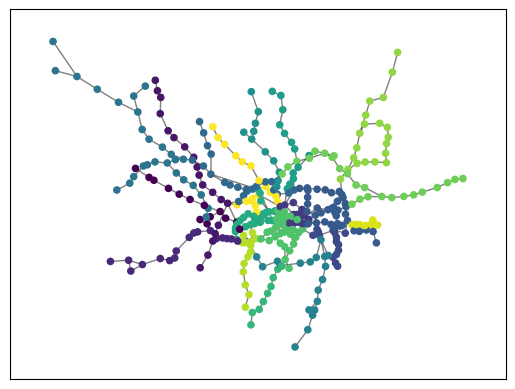

Number of communities detected: 19
Community 5: [0, 1, 10, 11, 12, 36, 58, 59, 65, 66, 74, 75, 76, 77, 106, 108, 111, 112, 113, 149, 150, 156, 217, 218, 219, 220, 251, 269, 270, 289, 290, 291, 323, 324, 326, 347, 348, 352, 353, 360]
Community 1: [2, 3, 92, 93, 116, 215, 216, 224, 225, 227, 228, 229, 233, 263, 264, 304, 305, 331, 364]
Community 2: [4, 5, 6, 71, 72, 221, 234, 235, 236, 237, 238, 248, 249, 250, 301, 328, 345]
Community 3: [7, 8, 9, 19, 20, 30, 37, 38, 39, 60, 61, 109, 110, 179, 181, 184, 295]
Community 7: [13, 14, 15, 16, 117, 122, 125, 140, 141, 165, 166, 167, 230, 232, 242, 243, 244, 253, 296, 297, 300, 302, 307, 308, 329, 342, 354]
Community 8: [17, 18, 82, 83, 84, 103, 128, 129, 153, 193, 194, 254, 255, 309, 317, 318, 327, 355, 356]
Community 9: [21, 22, 168, 169, 186, 240, 241, 262, 294, 359, 365]


In [14]:
#Louvain method
# Assuming G_multiplex is your network graph

# Detecting communities with the Louvain method
partition = community_louvain.best_partition(G_multiplex)

# Visualizing the detected communities
# Each community will be colored with a different color in the network
#pos = nx.spring_layout(G_multiplex)  # positions for all nodes
pos = {node: (data['long'], data['lat']) for node, data in G_multiplex.nodes(data=True)}

# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G_multiplex, pos, partition.keys(), node_size=20,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G_multiplex, pos, alpha=0.5)
plt.show()

# Print the number of communities detected
print(f"Number of communities detected: {max(partition.values()) + 1}")

# Optionally, to inspect nodes in each community:
from collections import defaultdict
communities = defaultdict(list)
for node, community in partition.items():
    communities[community].append(node)

# Print out nodes in the first few communities
for i, (community, nodes) in enumerate(communities.items()):
    print(f"Community {community}: {nodes}")
    if i > 5:  # Limit to printing only the first few communities
        break

The Louvain method's detection of 17 communities within the London transport network highlights the intricate modular structure that exists within this complex system. This method, known for its efficiency in detecting high-quality community structures in large networks, has identified distinct groups of stations (or nodes) that are more densely interconnected with each other than with the rest of the network. Here's an analysis based on the initial seven communities listed:

Insights from Community Structures
Geographical or Functional Clustering: The communities identified might correspond to geographical areas within London or specific functional groups, such as lines or sets of lines serving particular zones (e.g., central, suburban). For instance, Community 0, with its 36 members, might represent a core central area or a heavily trafficked route, given its size and likely centrality.
Community Size Variation: The size variation between communities, such as the larger Community 0 and smaller Community 5, suggests differences in network density, station importance, or passenger flow within these areas. Larger communities might indicate areas with more stations and higher connectivity, potentially reflecting urban density or key transport corridors.
Operational and Strategic Implications:
Focused Service Optimization: Understanding the specific needs and characteristics of each community can guide more targeted service optimization, such as frequency adjustments, capacity enhancements, or the introduction of express services within or between densely connected communities.
Infrastructure Development: Identifying communities can aid in pinpointing where new infrastructure developments or upgrades can most effectively enhance connectivity, capacity, and service quality, both within communities and across the broader network.
Emergency Preparedness: Recognizing the community structure aids in planning for emergencies or disruptions. Strategies can be developed to ensure that alternative services or routes are available to maintain connectivity, especially for communities that serve as critical hubs.
Planning and Development Considerations
Inter-Community Connectivity: While strengthening the internal connectivity within communities is important, enhancing connections between communities is crucial for ensuring network cohesion and facilitating efficient city-wide mobility. This might involve creating new transit links or improving existing ones between adjacent communities.
Community-Specific Strategies: Each community may have unique characteristics and serve different roles within the transport network. For example, a community primarily composed of residential areas may have different peak times and service requirements than one centered around commercial districts or tourist attractions. Tailoring strategies to the specific dynamics of each community can improve overall network efficiency and user satisfaction.
Resilience and Redundancy: The modularity highlighted by the Louvain method's community detection can also inform resilience planning. Ensuring that there are multiple, redundant paths within and between communities can make the network more resilient to disruptions, whether due to planned maintenance or unexpected events.
The Louvain method's ability to uncover these communities within the London transport network provides valuable insights into its structural and functional organization. This information can be leveraged for strategic planning, service optimization, and infrastructure development to enhance the network's efficiency, resilience, and service quality to meet the diverse needs of its users.

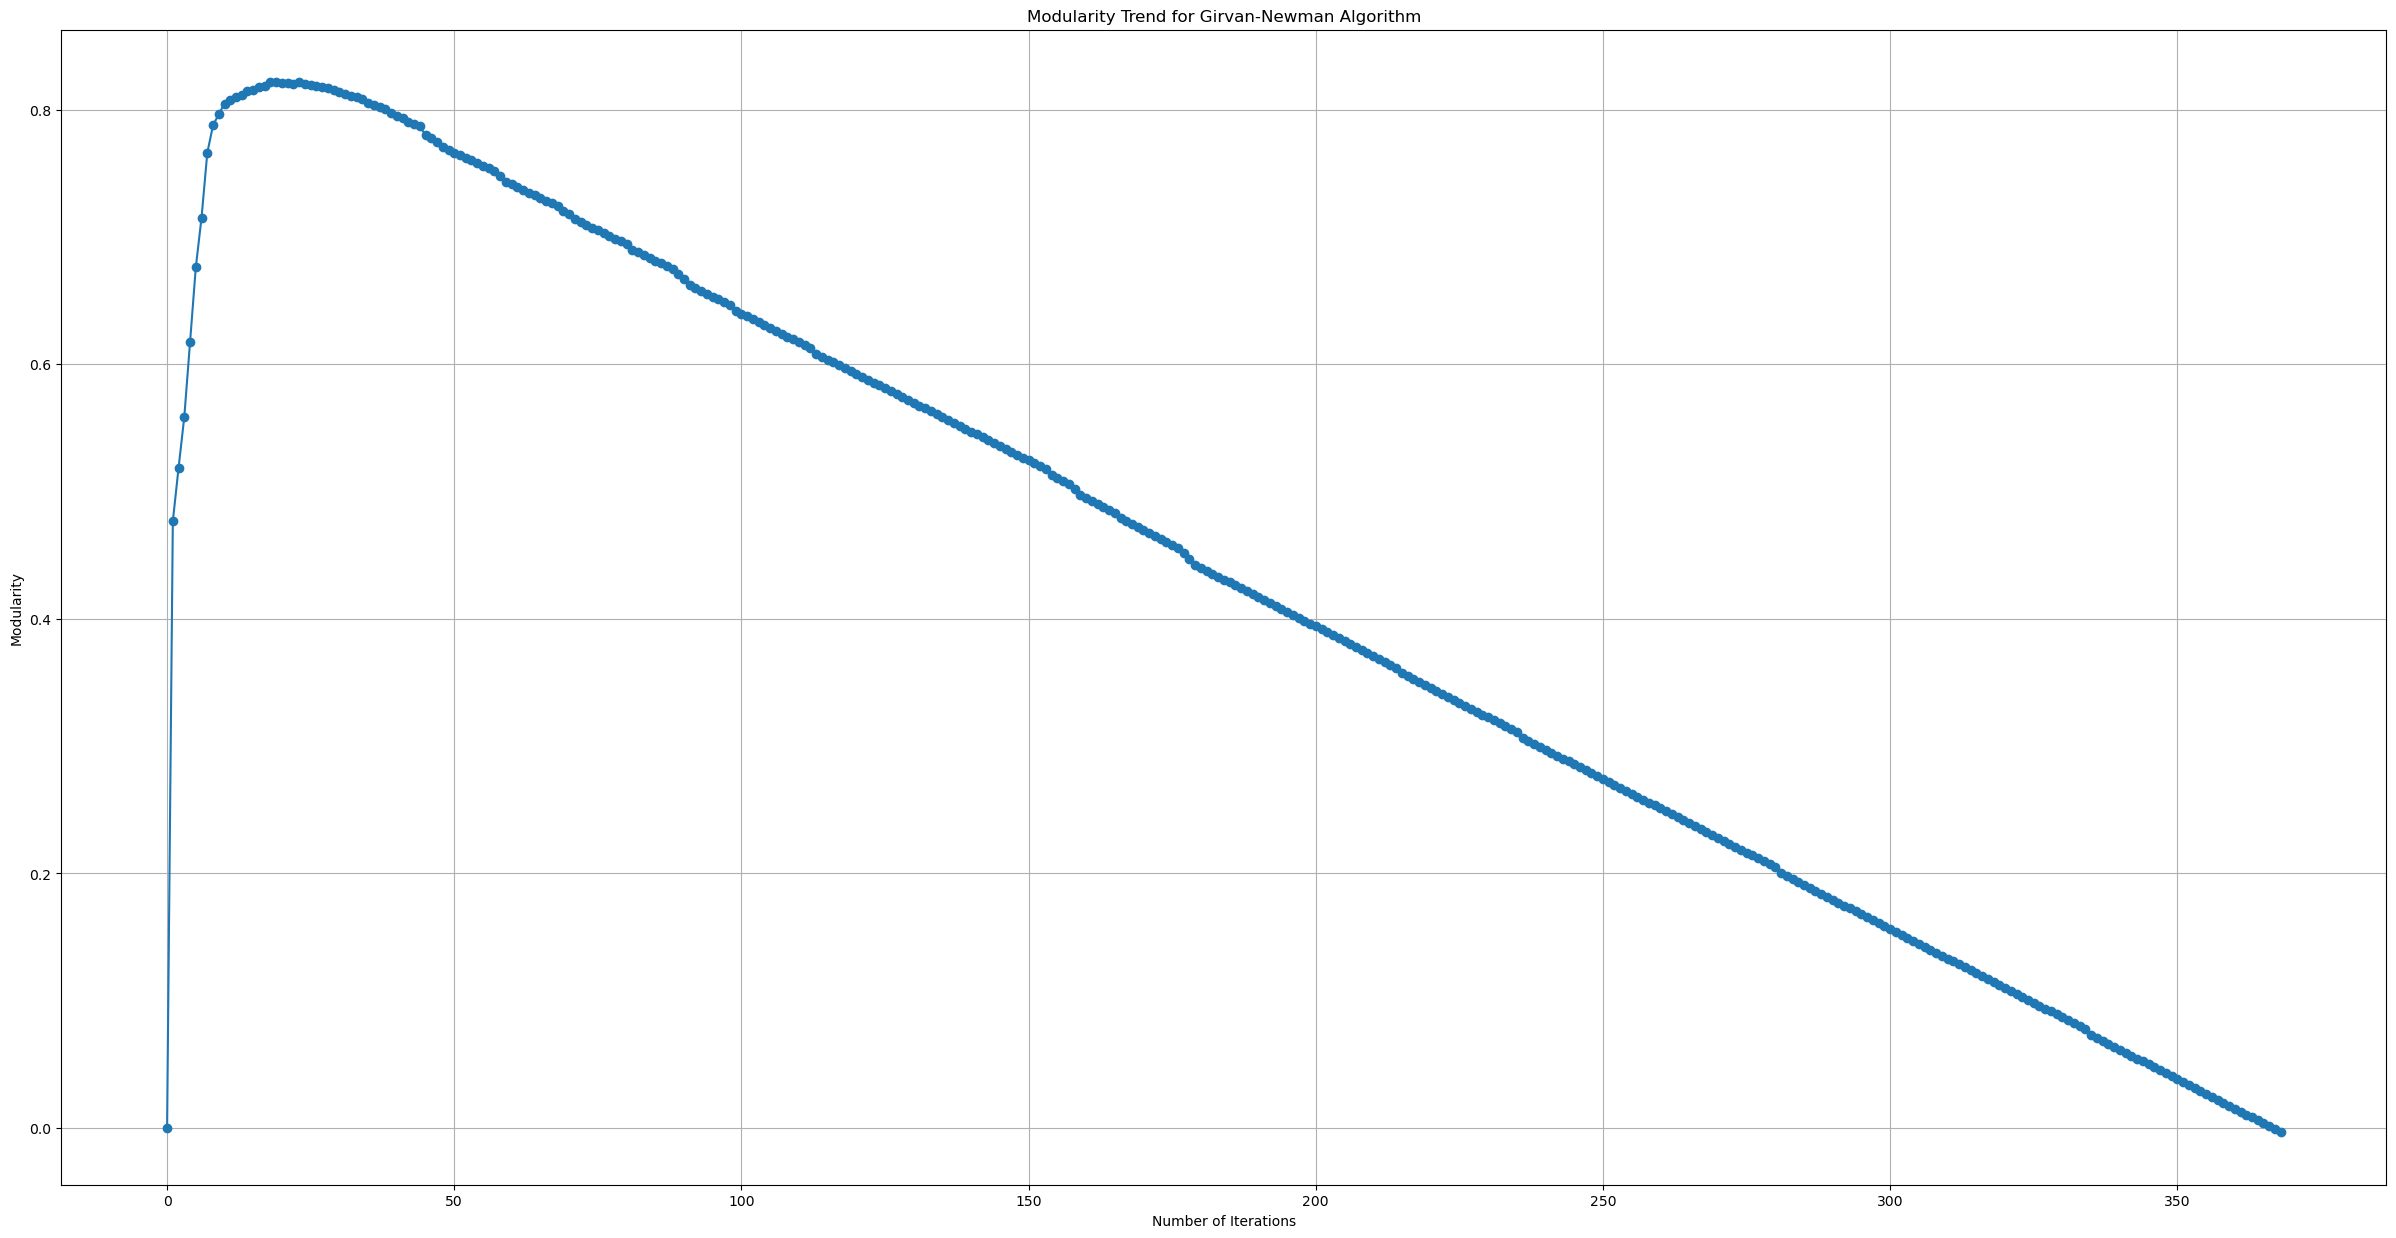

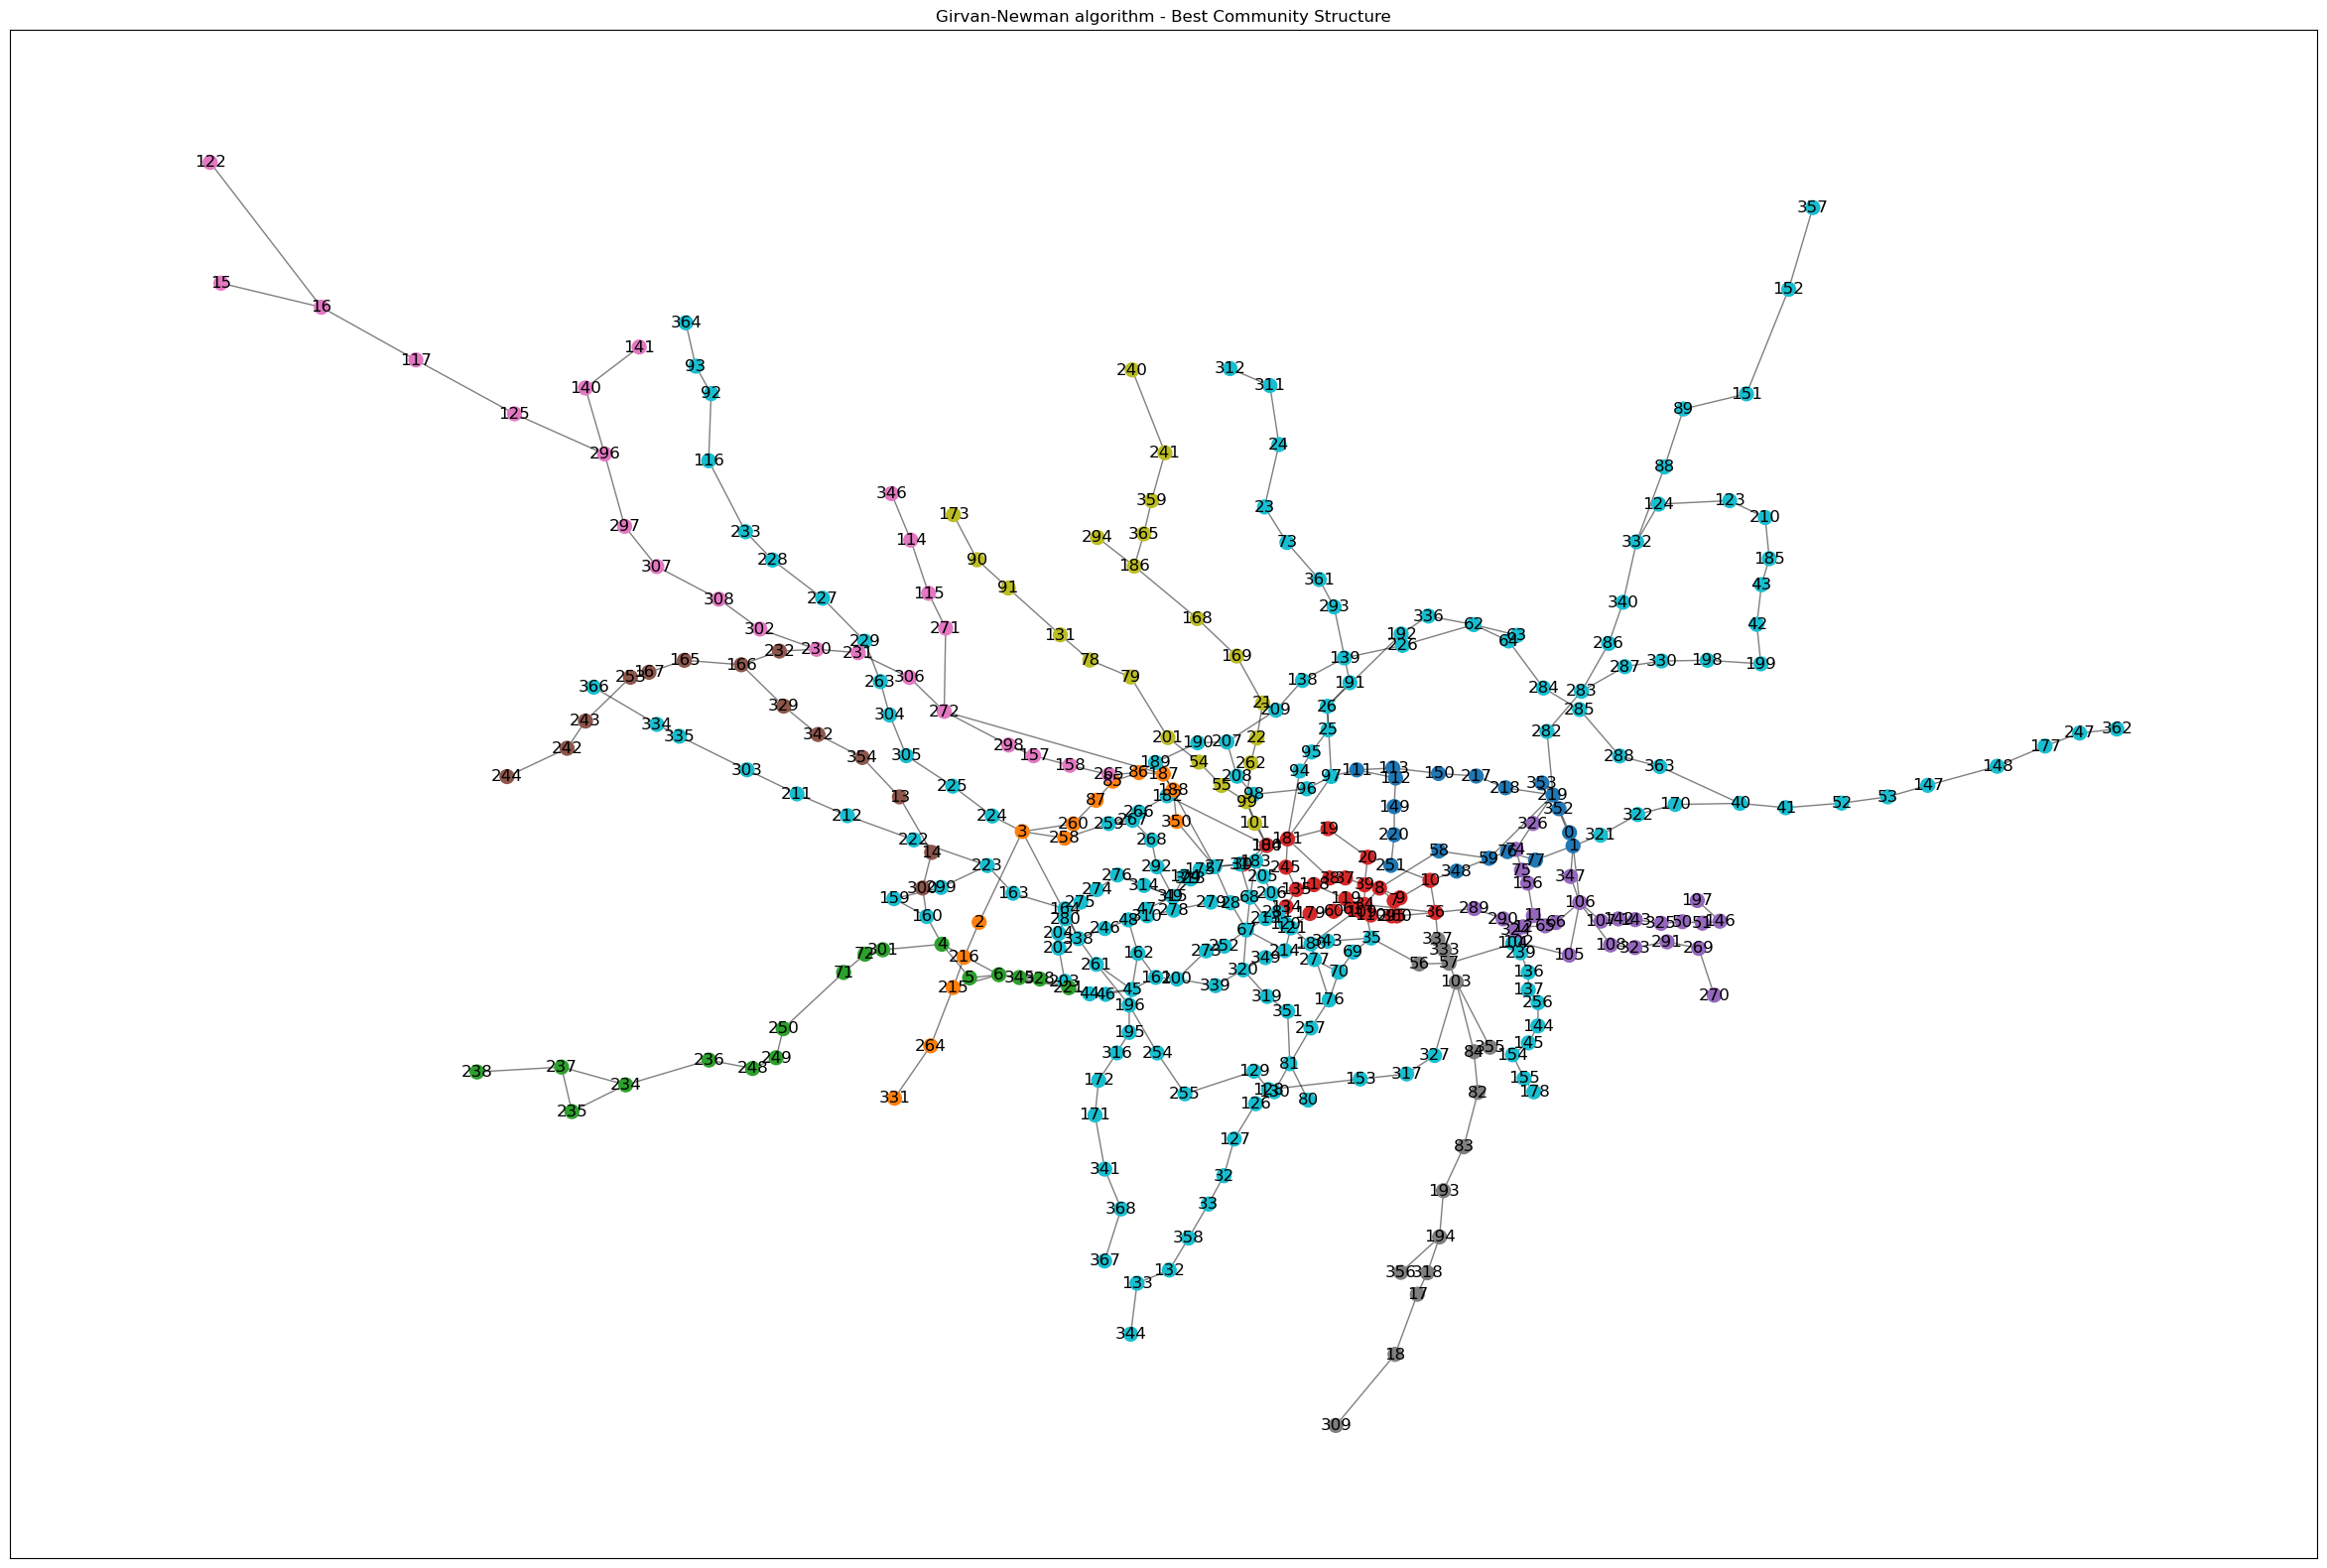

In [15]:
# Apply the Girvan-Newman algorithm
communities_generator = girvan_newman(G_multiplex)
modularity_values = []
num_iterations = []
communities_list = []

# Calculate initial modularity
initial_communities = tuple(sorted(c) for c in nx.connected_components(G_multiplex))
initial_modularity = modularity(G_multiplex, initial_communities)
modularity_values.append(initial_modularity)
num_iterations.append(0)
communities_list.append(initial_communities)

# Girvan-Newman iterative process
i = 1
try:
    while True:
        communities = next(communities_generator)
        curr_modularity = modularity(G_multiplex, communities)
        modularity_values.append(curr_modularity)
        num_iterations.append(i)
        communities_list.append(communities)
        i += 1
except StopIteration:
    pass  # When the generator has no more communities, it will raise StopIteration.

# Plotting the trend
plt.figure(figsize=(30, 15))
plt.plot(num_iterations, modularity_values, marker='o')
plt.title('Modularity Trend for Girvan-Newman Algorithm')
plt.xlabel('Number of Iterations')
plt.ylabel('Modularity')
plt.grid(True)
plt.show()

# Assuming you want to visualize the community with the highest modularity
best_iteration = modularity_values.index(max(modularity_values))
best_communities = communities_list[best_iteration]

# Create a color map for the graph with the best community structure
color_map = []
for node in G_multiplex:
    for index, community in enumerate(best_communities):
        if node in community:
            color_map.append(plt.cm.tab10(index))

plt.figure(figsize=(30, 20))
# Draw the graph
#pos = nx.spring_layout(G_multiplex)  # Position layout for consistent node placement
pos = {node: (data['long'], data['lat']) for node, data in G_multiplex.nodes(data=True)}
nx.draw_networkx_edges(G_multiplex, pos, alpha=0.5)
nx.draw_networkx_nodes(G_multiplex, pos, node_color=color_map, node_size=100)
nx.draw_networkx_labels(G_multiplex, pos)

# Set the title of the plot
plt.title("Girvan-Newman algorithm - Best Community Structure")

# Display the plot
plt.show()

In [16]:
communities_list
with open('your_file.txt', 'w') as f:
    for line in communities_list:
        f.write(f"{line}\n")
        

The Girvan-Newman algorithm is a method used in network science to detect communities within a graph. It does so by iteratively removing edges with the highest betweenness centrality, a measure of the number of shortest paths that pass through an edge. By removing these edges, the graph gradually splits into communities, or groups of nodes, that are more densely connected to each other than to the rest of the network. The process is guided by the modularity score, which quantifies the strength of division of a network into communities. A higher modularity score indicates a configuration where nodes within communities are more connected to each other than expected in a random network configuration.

Inferences from the Communities and Modularity Scores
Distinct Communities Indicate Specialization or Functional Separation: The Girvan-Newman algorithm's identification of 17 communities within the London transport network suggests a significant degree of specialization or functional separation. These communities could represent different geographical areas, transport lines, or networks serving distinct functions (e.g., commuter routes versus central city circulators).
High Modularity Scores Reflect Strong Community Structure: The observed modularity scores, particularly the peak scores around 0.82, indicate a strong community structure. This implies that the network is not a random mesh of connections but is instead organized into sub-networks with dense internal connections and sparser connections between these sub-networks. This structure can enhance the efficiency of the transport system by facilitating local movement within communities while maintaining connectivity across the broader network.
Peak Modularity and Network Optimization: The peak modularity score represents an optimal division of the network into communities. At this point, the network's division aligns with the inherent structural and functional groupings within the transport system. Understanding these groupings can inform network optimization strategies, highlighting areas where connectivity can be enhanced to improve network cohesion or where investments can target strengthening community-specific infrastructure.
Community Overlap and Interconnectivity: While communities represent more internally connected groups, the importance of edges that were removed last—those that connect different communities—should not be underestimated. These connections are critical for maintaining the overall connectivity and functionality of the transport network, facilitating movement across the entire city. Planning efforts should ensure these inter-community links are efficient and robust to support seamless city-wide transit.
Strategic Planning for Network Resilience: The algorithm's community detection can also guide resilience planning. By identifying communities and the critical connections between them, planners can develop strategies to mitigate the impact of disruptions, ensuring alternative routes and modes are available to maintain network functionality.

## 6. Inference from Analysis
### 6.1 Network Density

Network Density: 0.006841081459139291

Interpretation:
The network's low density indicates it is sparse, which is expected in large-scale transportation networks. This suggests that, on average, stations are not directly connected to many others, reflecting a network optimized for coverage rather than redundancy.

Implication: The sparse nature may impact the network's resilience to disruptions, as there are fewer alternative paths between any two stations. However, it can also indicate efficiency in design, preventing unnecessarily complex connections that could complicate navigation and maintenance.

### 6.2 Centrality
#### 6.2.1 Degree Centrality
Interpretation:
The Degree Centrality distribution highlights nodes with a high number of direct connections. The plot shows that most nodes have a relatively low degree of centrality, indicating they are directly connected to only a few other nodes. However, there are outliers with significantly higher values, suggesting these are major hubs within the transport network.

Implication: Nodes with high degree centrality are crucial for the network's connectivity and may represent major stations or transfer points. These nodes are likely to be high-traffic areas and could be focal points for congestion, requiring strategic planning for capacity and flow management.

#### 6.2.2 Betweenness Centrality
Interpretation:
The Betweenness Centrality plot shows a similar skewed distribution, with most nodes having low betweenness centrality, while a few have much higher values. High betweenness centrality indicates nodes that frequently act as bridges in the shortest paths between other nodes.

Implication:
Nodes with high betweenness centrality are critical for maintaining the network's cohesion and facilitating efficient movement across different parts of the network. They are strategic points for minimizing disruption impacts and enhancing network resilience.

#### 6.2.3 Closeness Centrality
Interpretation:
The Closeness Centrality distribution also reveals a variation among nodes, with a few nodes having significantly higher closeness centrality. This indicates that these nodes are, on average, closer to all other nodes in the network, facilitating quicker access across the network.

Implication:
High closeness centrality nodes are strategically important for network efficiency, reducing travel times and improving accessibility. Enhancing these nodes' capacity and connectivity can further optimize network performance.

### 6.3 K Core
K-Core Nodes: 14

Interpretation:
The presence of a 14-node K-core indicates a robust core within the network where each node is interconnected with at least 14 others. This core represents a highly connected and resilient subset of the network.

Implication:
The K-core's robustness suggests it could maintain structural integrity even under significant stress or disruptions, serving as a backbone for the network's overall connectivity. Enhancing these core nodes could further improve network resilience and efficiency.

### 6.4 K-components
Interpretation:
The K-components analysis reveals structures within the network that are k-connected, meaning there are k node-independent paths between each pair of nodes in the component. The 2-component with nodes {1, 2, 3, 39, 49, 160, 162, 180, 181, 183, 214, 221, 295, 314} suggests these stations are robustly connected, with at least two independent paths ensuring connectivity between them.

Implication:
These components highlight the network's areas of resilience, where connectivity is maintained even if one path is disrupted. Focusing on enhancing connectivity within and between these components could further bolster the network's robustness against disruptions.

### 6.5 Connected Components
Number of Connected Components: 1

Interpretation:
Having a single connected component for the entire network indicates that every station is reachable from every other, directly or indirectly, ensuring comprehensive coverage and connectivity.

Implication:
This is a positive attribute for a transportation network, as it ensures network-wide accessibility. However, it also highlights the importance of maintaining the integrity of this single connected component to prevent network fragmentation due to disruptions.

### 6.6 Cliques
Num of Cliques: 310
Max Clique Size: 3

Interpretation:
Cliques represent groups of stations where each is directly connected to every other within the group. The existence of 310 cliques, with the largest being a trio of stations, indicates multiple tightly-knit clusters within the network.

Implication:
These cliques likely represent local hubs or closely situated stations, providing redundancy for intra-region connectivity. Enhancing these cliques or creating new connections between them could improve local network resilience and passenger convenience.

## 7. Strategic Recommendations

1. Enhancing Core and Component Resilience:

Prioritizing investments in the network's K-core and significant K-components can bolster the network's overall resilience. This might involve upgrading infrastructure, increasing service frequency, or implementing advanced monitoring and rapid response systems to ensure these critical nodes and paths remain operational under various scenarios.

2. Optimizing Design for Redundancy and Efficiency:

Balancing the network's sparse design with strategic redundancy where necessary can mitigate vulnerability points. This could include creating new connections between cliques or enhancing existing paths to provide alternative routes, reducing the risk of significant service disruptions.

3. Leveraging Localized Connectivity:

Recognizing and leveraging the role of cliques in providing localized connectivity and redundancy offers opportunities to enhance passenger experience and operational resilience. This could involve targeted improvements in these areas to streamline connections, reduce congestion, and provide more reliable service options.

## 8. Conclusion
The London transport network exhibits a carefully balanced design that optimizes for coverage, efficiency, and, to a certain extent, resilience. The insights from this analysis not only highlight the network's structural strengths and potential vulnerabilities but also offer a roadmap for targeted enhancements. By focusing on strengthening critical nodes and connections, optimizing for both efficiency and redundancy, and leveraging localized connectivity, the network can improve its robustness, operational reliability, and service quality, ensuring it remains well-equipped to meet both current and future challenges.